O problema analizado é o caixeiro viajante com cidades dispostas ao longo de uma esctrela. O problema é equivalente ao de cidades dispostas ao longo de um circulo, mas com raio variável. Os mínimos continuam sendo os casos em que as cidades seguem ordem crescente ou decrescente.

In [66]:
using Random
using LinearAlgebra
using Plots; gr()
using TimerOutputs
using Waveforms
using ProgressMeter

cidades = 60
raioBase = 0.8506508

fatorNormalizacao = 1
raioPentagono = (raioBase .+ 0.2*trianglewave.(10*pi.*(0:cidades-1)./(cidades)) .+ 0.2)
x = raioPentagono.*[cos.(2 .* pi .* (0:cidades-1) ./ cidades) sin.(2 .* pi .* (0:cidades-1) ./ cidades)];

HMenorJ = true
N = 1e5
T0 = 0.5
Kmax = 30
Jmin = 1e4
ordemMin = []
ordemOtima = 1:cidades
Js = []
Ts = []
distancias = []
temperaturas = [];

In [67]:
# O custo é a distancia total percorrida
custos = zeros(cidades, cidades)

for i = 1:cidades
    for j = 1:cidades
        custos[i, j] = norm(x[i, :]-x[j, :])
    end
end

function J(ordem)
    distTot = 0
    dist = 0
    for i = 2:cidades
        dist = custos[ordem[i], ordem[i-1]]
        distTot += dist     
    end
    
    distTot += custos[ordem[end], ordem[1]]
    
    return distTot
end

Jotimo = J(ordemOtima)

7.722296358324144

In [68]:
# # Simulated Annealing
fim = false
seedFinal = 0
tempoFinal = 0
distancias = []
temperaturas = []
time = @elapsed begin
for seed = 1:5
    Random.seed!(seed);
    
    Jatual = 1e4
    Jmin = Jatual
    T = T0
    Js = []
    Ts = []
    
    
    # Ordem de caminhos inicial aleatoria
    ordem = [1; shuffle(2:cidades)]
    ordemHat = copy(ordem)
    ordemMin = copy(ordem)
        
    
        @showprogress 1 "Computing..." for k = 1:Kmax
            for n = 1:N
                # Troca duas cidades de ordem de maneira aleatoria, exceto a primeira que é sempre a mesma
                idx = rand(2:cidades)
                idx2 = rand(2:cidades)
                while idx2 == idx
                    idx2 = rand(2:cidades)
                end
                ordemHat = copy(ordem)
                ordemHat[idx], ordemHat[idx2] = ordem[idx2], ordem[idx]

                Jit = J(ordemHat)

                q = exp((Jatual-Jit)/T)
                r = rand()

                if r < q
                    ordem = copy(ordemHat)
                    Jatual = Jit
                end    

                if Jit < Jmin
                    Jmin = Jit

                    ordemMin = copy(ordemHat)
                    if (Jmin - Jotimo) < 0.001
                        append!(distancias, Jit)
                        append!(temperaturas,T)
                        println("\nMinimo")
#                         tempoFinal = time
                        seedFinal = seed
                        fim = true
                        break
                    end
                end

                append!(distancias, Jit)
                append!(temperaturas,T)
            end
            if fim
                break
            end
            T = T0/(log2(1 + k))

            if HMenorJ
                ordem = copy(ordemMin)
            end
        end
        if fim
            break
        end
    end   
end
println("Tempo necessário:\n", time)
tempoFinal = time;

Computing... 100%|███████████████████████████████████████| Time: 0:00:32
Computing... 100%|███████████████████████████████████████| Time: 0:00:38
Computing... 100%|███████████████████████████████████████| Time: 0:00:44
Computing... 100%|███████████████████████████████████████| Time: 0:00:49
Computing... 100%|███████████████████████████████████████| Time: 0:00:53


Tempo necessário:
218.246738


Jmin: 9.143464768676905
Jotimo: 7.722296358324144


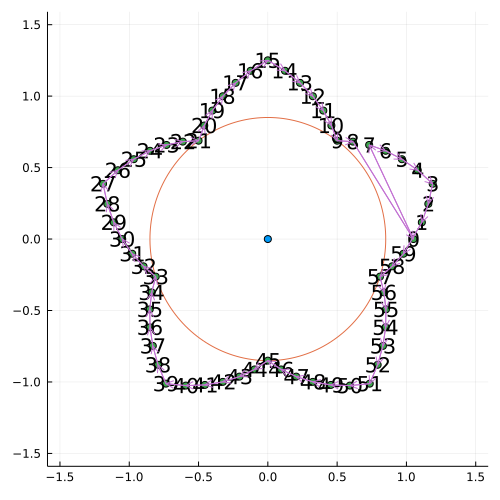

In [69]:

# Visualização do resultado final


println("Jmin: ", Jmin)
println("Jotimo: ", Jotimo)
plot([0], [0], seriestype = :scatter, xlim=[-1.5, 1.5], ylim=[-1.5, 1.5], size = (500, 500), grid = true)
xt(t) = sin(t)*raioBase
yt(t) = cos(t)*raioBase
plot!(xt, yt, 0, 2*pi, leg=false)
plot!(x[:, 1], x[:, 2], seriestype = :scatter, mode="markers+text", text=0:cidades-1)


quiver!(x[ordemMin, 1],x[ordemMin, 2],quiver=(x[[ordemMin[2:end]; 1], 1] - x[ordemMin, 1],x[[ordemMin[2:end]; 1], 2] - x[ordemMin, 2])) 
# quiver!(x[ordemOtima, 1],x[ordemOtima, 2],quiver=(x[[ordemOtima[2:end]; 1], 1] - x[ordemOtima, 1],x[[ordemOtima[2:end]; 1], 2] - x[ordemOtima, 2])) 



In [70]:
step = 100
plot(1:step:length(distancias), distancias[1:step:end], label = "J", lw = 3, size = (1000, 200))
plot!(1:step:length(distancias), ones(length(distancias[1:step:end]), 1)*Jotimo, label = "Jotimo", lw = 3)
plot!(1:step:length(distancias), temperaturas[1:step:end]*maximum(distancias), label = "Temperaturas x max(J)", lw = 3)
# xlabel!("Iterações")
ylabel!("Custo")
# savefig(string("custo_", cidades, HMenorJ, ".png"))

In [71]:


otimo = false
if (Jmin - Jotimo) < 0.001
    otimo = true
end
# header: C,T,N,Kmax,Jmin,Tempo,HMenorJ,O
resultados = string(cidades, ",", T0 ,"," , N , "," , Kmax , "," , Jmin , "," , tempoFinal, ",", HMenorJ, "," , seedFinal , ",", otimo, "\n")
println(resultados)

open("resultados2.csv","a") do io
    write(io, resultados)
end;

60,0.5,100000.0,30,9.143464768676905,218.246738,true,0,false

